In [1]:
import collections
import dataclasses
import math
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.signal
import PIL.Image

from ntsc import *

%matplotlib inline

In [2]:
class Decoder:
    """
    Initialise with a sample rate in MHz.
    
    """
    sample_rate: float # MHz
    time: float # µs
    colour_burst_freq: float # MHz
    colour_burst_phase: float # Radians
    
    h_sync_frequency: float # MHz
    h_sync_offset: float # µs
    
    def __init__(self, sample_rate: float):
        self.sample_rate = sample_rate
        self.time = 0.0
        
        # Initial values for state
        self.colour_burst_freq = COLOUR_CARRIER_FREQUENCY
        self.colour_burst_phase = 0.0
        self.h_sync_frequency = 1.0 / LINE_DURATION
        self.h_sync_offset = 0.0
        
        # Compute chroma bandpass filter based on the nominal colour burst frequency.
        self._chroma_bp_ba = scipy.signal.iirpeak(
            COLOUR_CARRIER_FREQUENCY, Q=3, fs=self.sample_rate
        )
        
        # Compute demodulated chroma sigla lowpass filter based on the nominal colour burst frequency.
        self._chroma_low_sos = scipy.signal.butter(
            1, 0.2 * COLOUR_CARRIER_FREQUENCY,
            analog=False, btype="lowpass", fs=sample_rate, output="sos"
        )

        # We restore the vertical sync by low-pass filtering the composite sync.
        # Create a simple second order Butterworth filter for filtering out the vsync.
        self._vsync_lp_sos = scipy.signal.butter(
            2, 0.8 * self.h_sync_frequency, analog=False, btype="low", fs=self.sample_rate, output="sos"
        )
        
        # We keep a small portion of the previous block around so that our filters
        # don't need to be padded backwards in time
        self.previous_block = np.zeros((0,))
        
        # Previous hsync time to help us filter out transient edges
        self.previous_h_sync_edge_time = 0.0
        
        # Previous vsync time to help generate ramp signal
        self.previous_v_sync_edge_time = 0.0
        
        # Previous hsync and vsync ramp signal end samples to help detect edges
        self.previous_h_sync_ramp_value = 0.0
        self.previous_v_sync_ramp_value = 0.0
        
        # Undecoded line portion from previous block(s)
        self.previous_line_v_sync_ramp = np.zeros((0,))
        self.previous_line_luma = np.zeros((0,))
        self.previous_line_chroma = np.zeros((0,))
        
        # 0-based index of line we're currently decoding
        self.line_index = 0
        
        # Current full frame
        self.full_frame = np.zeros((FRAME_ACTIVE_LINES, FRAME_H_PIXELS, 3))
                        
    def _separarate_chroma(self, signal):
        """
        Return the luma and choma components of the passed signal.
        
        """
        chroma = scipy.signal.filtfilt(*self._chroma_bp_ba, x=signal)
        return signal - chroma, chroma
    
    def _compute_h_sync(self, times):
        """
        Given absolute times, return hsync ramp signal
        
        """
        return np.fmod((times - self.h_sync_offset) * self.h_sync_frequency, 1)
    
    def _reconstruct_colourburst_phase(self, cb_times, cb_samples):
        complex_cb = COLOUR_CARRIER_AMPLITUDE * np.exp(1j * self.colour_burst_freq * 2 * np.pi * cb_times)
        response = np.sum(cb_samples * complex_cb)
        cb_phase = -np.angle(response)
        return cb_phase
    
    def _decode_line(self, line_time, luma, chroma):
        # The line must be roughly the right length.
        if luma.shape[0] < 0.5 * LINE_DURATION / self.sample_rate:
            return np.ones((FRAME_H_PIXELS, 3)) * 0.5
        
        # Luma is fairly easy
        line_y = (luma - BLACK_LEVEL) / (WHITE_LEVEL - BLACK_LEVEL)
        
        # Times of line samples.
        line_times = line_time + np.arange(luma.shape[0]) / sample_rate
     
        # Extract colour burst from chroma bandpass filtered signal
        cb_start_sample = int(math.floor(COLOUR_BURST_START_TIME * sample_rate))
        cb_sample_count = int(math.ceil(COLOUR_BURST_START_TIME * sample_rate))
        cb_samples = chroma[cb_start_sample:cb_start_sample+cb_sample_count]
        cb_times = line_times[cb_start_sample:cb_start_sample+cb_sample_count]

        # For the moment we do not attempt to track colourbust frequency.
        cb_phase = self._reconstruct_colourburst_phase(cb_times, cb_samples)
        
        # Fold in phase gradually
        cb_mix = 0.1
        self.colour_burst_phase = cb_mix * cb_phase + (1 - cb_mix) * self.colour_burst_phase
        
        # Compute I and Q chroma via demodulation.
        cb_subcarrier = np.exp(1j * (self.colour_burst_freq * 2 * np.pi * line_times + self.colour_burst_phase))
        line_i = np.real(cb_subcarrier) * chroma / COLOUR_CARRIER_AMPLITUDE
        line_q = np.imag(cb_subcarrier) * chroma / COLOUR_CARRIER_AMPLITUDE
        
        # Pass demodulation through lowpass filter using nominal chroma burst frequency.
        line_i = scipy.signal.sosfilt(self._chroma_low_sos, line_i)
        line_q = scipy.signal.sosfilt(self._chroma_low_sos, line_q)
        
        # Compute RGB for line.
        line_rgb = np.zeros((luma.shape[0], 3))
        line_rgb[..., 0] = line_i + line_y
        line_rgb[..., 2] = line_q + line_y
        line_rgb[..., 1] = (line_y - 0.3 * line_rgb[..., 0] - 0.11 * line_rgb[..., 2]) / 0.59

        # Re-sample line into pixels/
        pixel_times = H_SYNC_DURATION + BACK_PORCH_DURATION + np.arange(FRAME_H_PIXELS) * ACTIVE_DURATION / FRAME_H_PIXELS
        rgb_interp = scipy.interpolate.interp1d(
            x=line_times - line_time, y=line_rgb, axis=0, kind="quadratic", bounds_error=False, fill_value=0
        )
        return rgb_interp(pixel_times)

    def __call__(self, block):
        """
        Decode a block of samples. Returns a list of decoded fields. This
        list may be empty if more samples need to be consumed.
        
        """
        # Frames to return
        decoded_frames = []
        
        # Number of blank lines in a full frame
        n_blank_lines = FRAME_TOTAL_LINES - FRAME_ACTIVE_LINES
        
        # Number of samples within this block and its starting time.
        n_samples = block.shape[0]
        block_start_time = self.time
        
        # Time of samples within block
        block_times = np.arange(n_samples) / self.sample_rate + block_start_time
        
        # Pad block with previous block.
        padded_block = np.concatenate((self.previous_block, block))
        
        # Separate chroma and luma signal.
        luma, chroma = self._separarate_chroma(padded_block)
        
        # Compute composite sync by thresholding block.
        cs = np.where(padded_block < -25, 0, 1)
        cs_edges = np.logical_and(cs[:-1] > 0.5, cs[1:] < 0.5).nonzero()[0]
        
        # Compute vsync lowpass filter and edges where we detect vsync.
        v_sync_lowpass = scipy.signal.sosfilt(self._vsync_lp_sos, cs)
        v_sync_edge_indices = np.logical_and(v_sync_lowpass[:-1] > 0.66, v_sync_lowpass[1:] <= 0.66).nonzero()[0]
        
        # Detect hsync edges as -ve going pulses in composite sync.
        h_sync_edge_indices = np.logical_and(cs[:-1] > 0.5, cs[1:] <= 0.5).nonzero()[0]
        
        # Prune edge indices and signals outside of the current block
        luma = luma[self.previous_block.shape[0]:]
        chroma = chroma[self.previous_block.shape[0]:]
        cs = cs[self.previous_block.shape[0]:]
        v_sync_lowpass = v_sync_lowpass[self.previous_block.shape[0]:]
        h_sync_edge_indices -= self.previous_block.shape[0]
        h_sync_edge_indices = h_sync_edge_indices[h_sync_edge_indices >= 0]
        v_sync_edge_indices -= self.previous_block.shape[0]
        v_sync_edge_indices = v_sync_edge_indices[v_sync_edge_indices >= 0]
        
        # Compute the vsync ramp signal
        v_sync_ramp = np.zeros_like(block)
        prior_edge_idx = 0
        for edge_idx in np.concatenate((v_sync_edge_indices, [n_samples])):
            # Times *within* frame for this region of the signal
            times = block_times[prior_edge_idx:edge_idx] - self.previous_v_sync_edge_time
            
            # Compute vsync ramp signal based on field duration.
            v_sync_ramp[prior_edge_idx:edge_idx] = np.fmod(times / (LINE_DURATION * FRAME_TOTAL_LINES * 0.5), 1)
            prior_edge_idx = edge_idx

            # That's if if we're not a "real" edge but just the last part of the block.
            if edge_idx == n_samples:
                continue
            
            # If this is a "real" edge, record the edge time.
            self.previous_v_sync_edge_time = block_times[edge_idx]
        
        # Compute the hsync ramp signal
        h_sync_ramp = np.zeros_like(block)
        prior_edge_idx = 0
        for edge_idx in np.concatenate((h_sync_edge_indices, [n_samples])):
            # Times for this region of the signal
            times = block_times[prior_edge_idx:edge_idx]
            
            # Compute hsync signal which ranges from 0 to 1
            h_sync_ramp[prior_edge_idx:edge_idx] = self._compute_h_sync(times)
            prior_edge_idx = edge_idx

            # That's if if we're not a "real" edge but just the last part of the block.
            if edge_idx == n_samples:
                continue
            
            # If this is a "real" edge, adjust the h_sync offset.
            
            # Ignore pulses which are not close to where we expect to find one. This is
            # to ignore transient hsync pulses and the vsync pulses.
            edge_time = block_times[edge_idx]
            if edge_time - self.previous_h_sync_edge_time < LINE_DURATION * 0.75:
                continue

            # Get a measure of the position within the hsync ramp this edge lies
            # ranging from -0.5 to 0.5. If we're perfectly in sync, this should be
            # zero. If it is +ve we need to increase offset to shift hsync to the
            # right and vice versa.               
            position_within_h_sync = self._compute_h_sync(edge_time)
            if position_within_h_sync > 0.5:
                position_within_h_sync -= 1.0

            # Merge in phase change gradually. We don't yet update hsync frequency estimates.
            self.h_sync_offset += 0.01 * position_within_h_sync / self.h_sync_frequency

            # Record edge time.
            self.previous_h_sync_edge_time = edge_time
            
        # Re-construct "clean" hsync and vsync edges.
        augmented_h_sync_ramp = np.concatenate(([self.previous_h_sync_ramp_value], h_sync_ramp))
        clean_h_sync_edge_indices = np.logical_and(augmented_h_sync_ramp[:-1] > 0.5, augmented_h_sync_ramp[1:] <= 0.5).nonzero()[0]
        augmented_v_sync_ramp = np.concatenate(([self.previous_v_sync_ramp_value], v_sync_ramp))
        clean_v_sync_edge_indices = collections.deque(
            np.logical_and(augmented_v_sync_ramp[:-1] > 0.5, augmented_v_sync_ramp[1:] <= 0.5).nonzero()[0]
        )
        
        # Decode each line
        prior_edge_idx = 0
        for edge_idx in clean_h_sync_edge_indices:
            line_v_sync_ramp = np.concatenate((self.previous_line_v_sync_ramp, v_sync_ramp[prior_edge_idx:edge_idx]))
            line_luma = np.concatenate((self.previous_line_luma, luma[prior_edge_idx:edge_idx]))
            line_chroma = np.concatenate((self.previous_line_chroma, chroma[prior_edge_idx:edge_idx]))
            line_times = np.arange(line_luma.shape[0]) / self.sample_rate
            
            # Was there a vsync edge on this line?
            line_v_sync_edge_indices = np.logical_and(line_v_sync_ramp[:-1] > 0.5, line_v_sync_ramp[1:] <= 0.5).nonzero()[0]
            if line_v_sync_edge_indices.shape[0] > 0:
                decoded_frames.append(self.full_frame.copy())
                
                # If we're before half way through, we're an even frame
                if line_v_sync_edge_indices[0] < line_luma.shape[0] * 0.5:
                    self.line_index = 7
                else:
                    self.line_index = 6

            # Decode line and record in full frame if appropriate.
            line_rgb = self._decode_line(block_times[edge_idx] - line_luma.shape[0] / self.sample_rate, line_luma, line_chroma)            
            if self.line_index >= n_blank_lines and self.line_index < FRAME_TOTAL_LINES:
                self.full_frame[self.line_index - n_blank_lines, ...] = line_rgb
                    
            prior_edge_idx = edge_idx
            self.previous_line_luma = np.zeros((0,))
            self.previous_line_chroma = np.zeros((0,))
            self.previous_line_v_sync_ramp = np.zeros((0,))
            self.line_index += 2
            
        # Save undecoded line portion
        if clean_h_sync_edge_indices.shape[0] > 0:
            self.previous_line_luma = luma[clean_h_sync_edge_indices[-1]:]
            self.previous_line_chroma = chroma[clean_h_sync_edge_indices[-1]:]
            self.previous_line_v_sync_ramp = v_sync_ramp[clean_h_sync_edge_indices[-1]:]
        else:
            self.previous_line_luma = np.concatenate((self.previous_line_luma, luma))
            self.previous_line_chroma = np.concatenate((self.previous_line_chroma, chroma))
            self.previous_line_v_sync_ramp = np.concatenate((self.previous_line_v_sync_ramp, v_sync_ramp))
        
        # Record last ~100µs of block as the next "previous" block.
        self.previous_block = block[-int(math.ceil(100 / self.sample_rate)):]
        
        # Update rolling state.
        self.time += n_samples / self.sample_rate
        self.previous_h_sync_ramp_value = h_sync_ramp[-1]
        self.previous_v_sync_ramp_value = v_sync_ramp[-1]
        
        return decoded_frames

t=14000µs


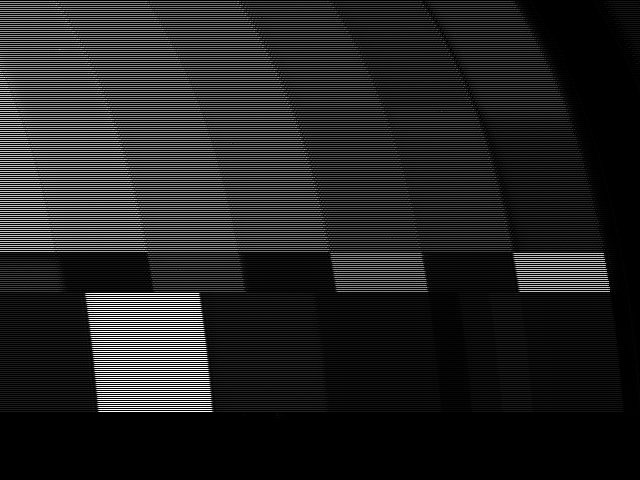

saved decoded-0001.png
t=31001µs


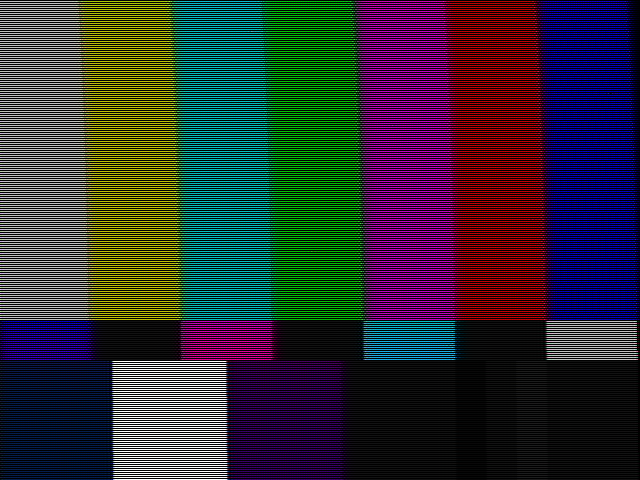

saved decoded-0002.png
t=48001µs


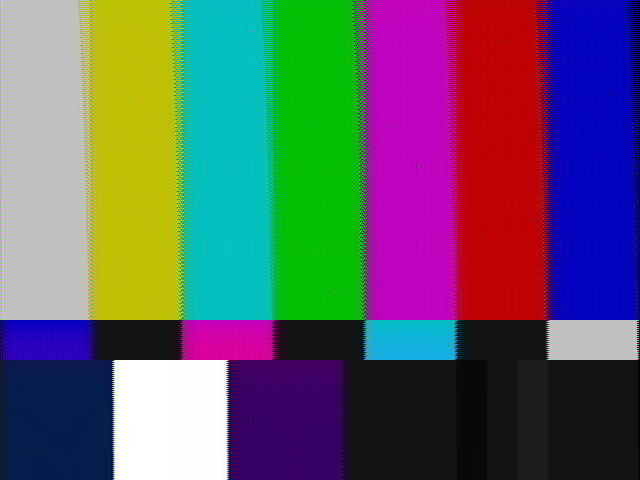

saved decoded-0003.png
t=64001µs


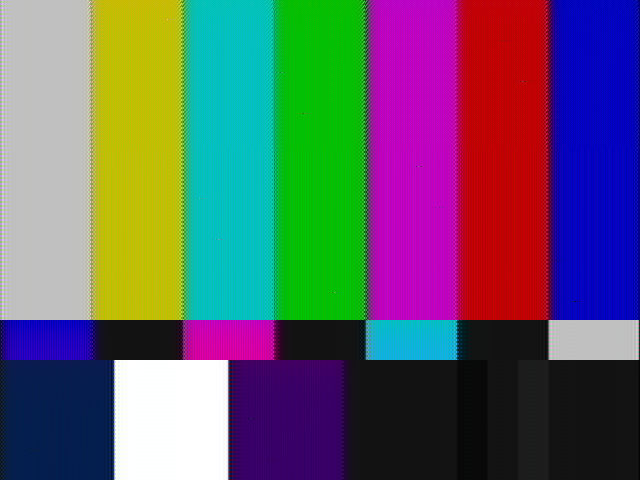

saved decoded-0004.png
t=81002µs


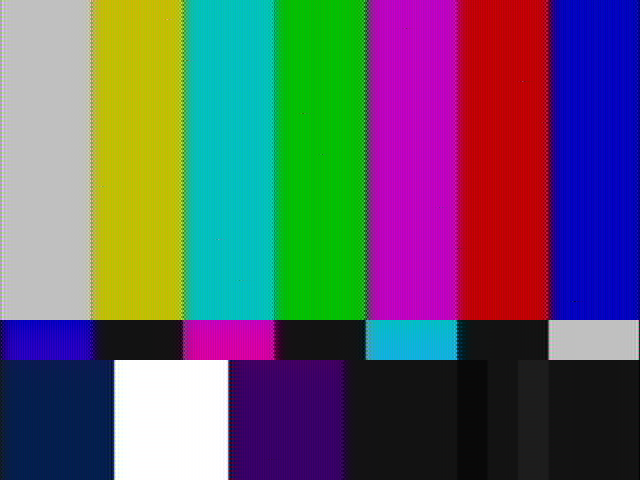

saved decoded-0005.png
saved decoded-0006.png
saved decoded-0007.png
saved decoded-0008.png
saved decoded-0009.png
saved decoded-0010.png
saved decoded-0011.png
saved decoded-0012.png
saved decoded-0013.png
saved decoded-0014.png
saved decoded-0015.png
saved decoded-0016.png
saved decoded-0017.png
saved decoded-0018.png
saved decoded-0019.png
saved decoded-0020.png
saved decoded-0021.png
saved decoded-0022.png
saved decoded-0023.png
saved decoded-0024.png
saved decoded-0025.png
saved decoded-0026.png
saved decoded-0027.png
saved decoded-0028.png
saved decoded-0029.png
saved decoded-0030.png
saved decoded-0031.png
saved decoded-0032.png
saved decoded-0033.png
saved decoded-0034.png
saved decoded-0035.png
saved decoded-0036.png
saved decoded-0037.png
saved decoded-0038.png
saved decoded-0039.png
saved decoded-0040.png
saved decoded-0041.png
saved decoded-0042.png
saved decoded-0043.png
saved decoded-0044.png
saved decoded-0045.png
saved decoded-0046.png
saved decoded-0047.png
saved decod

In [3]:
with np.load("./tv-signal.npz") as f:
    signal = f["signal"]
    sample_rate = f["sample_rate"]
    
# Start the signal a few lines in so we're forced to synchronise
signal = signal[int(LINE_DURATION * 33.2 * sample_rate):]
    
# Initialise the decoder
decode = Decoder(sample_rate)

# Work in blocks of ~100µs
block_size = int(math.ceil(1000 * sample_rate))

# Decode frames
block_start = 0
frame_idx = 0
n_blocks = 0
frame_skip = 0
while block_start < signal.shape[0]:
    block = signal[block_start:block_start+block_size]
    frame_images = decode(block)
    
    for im in frame_images:
        im = PIL.Image.fromarray(np.clip(im * 255, 0, 255).astype(np.uint8))
        if frame_idx < 5:
            print(f"t={block_start / sample_rate:.0f}µs")
            display(im)
        if frame_idx >= frame_skip:
            frame_filename = f"decoded-{1+frame_idx-frame_skip:04d}.png"
            im.save(frame_filename)
            print(f"saved {frame_filename}") 
        frame_idx += 1

    block_start += block.shape[0]
    n_blocks += 1